# Brent Oil Price Forecast with XGBoost

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt

## Reading dataset

In [2]:
df = pd.read_excel(io='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls', sheet_name='Data 1', skiprows = 2)
df = df.rename({'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'}, axis='columns')
df.shape

(9110, 2)

## Drop negative prices if any

In [3]:
indexNames = df[df['Price'] < 0].index
df.drop(indexNames , inplace=True)
df.shape

(9110, 2)

## Filling date gaps

For market closed dates, use the previous date's price.

In [4]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace = True)
#fill date gaps
df = df.resample('D').fillna('ffill')
#fix the Date column
df.Date = df.index.values
df.reset_index(drop = True, inplace = True)
n_days = df.shape[0]
df.shape

(13110, 2)

In [5]:
df.tail()

,Date,Price
13105,2023-04-06,86.56
13106,2023-04-07,86.56
13107,2023-04-08,86.56
13108,2023-04-09,86.56
13109,2023-04-10,86.56


## Save as csv

In [6]:
df.to_csv('oil.csv', index = False)

## Visualizing the time series dataset

In [7]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

Text(0.5, 1.0, 'Brent Oil Price')

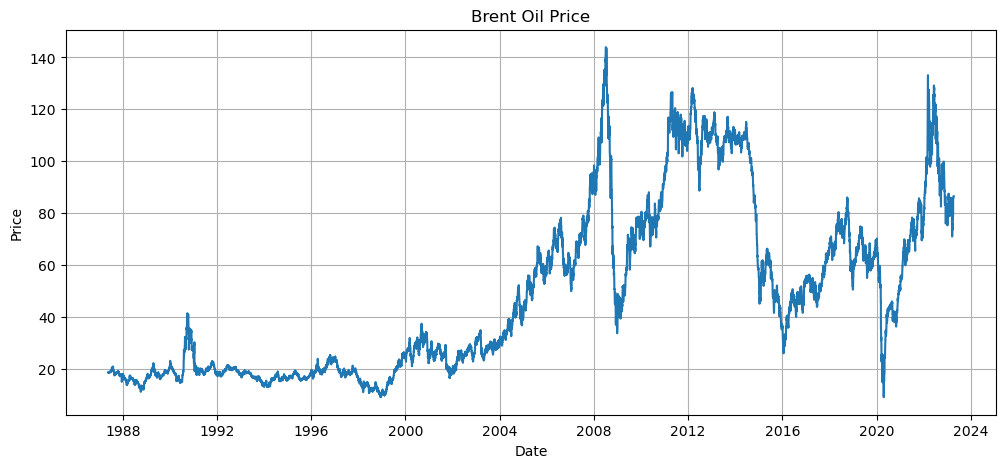

In [8]:
plt.figure(figsize=(12, 5))
plot_series(df['Date'], df['Price'])
plt.title('Brent Oil Price')

## Functions

In [9]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]

    df = DataFrame(data)

    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))

    # put it all together
    agg = concat(cols, axis = 1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)

    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000)

    model.fit(trainX, trainy)
    
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0], model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, model = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        if n_test <= 30 or i % 10 == 0: 
            print('%d: Actuarial = %.1f, Predicted = %.1f' % (i, testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)

    return error, test[:, -1], predictions, model

## Training the model

In [10]:
# load the dataset
series = read_csv('oil.csv', header = 0, index_col = 0)
values = series.values

In [11]:
n_test = 365
split_time = len(df) - n_test
test_time = df[['Date']][split_time:]

In [12]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in = 30, n_out = 1)
# evaluate
mae, y, yhat, model = walk_forward_validation(data, n_test)
print('MAE: %.3f' % mae)

0: Actuarial = 97.9, Predicted = 102.2
10: Actuarial = 107.2, Predicted = 104.7
20: Actuarial = 108.4, Predicted = 108.7
30: Actuarial = 107.7, Predicted = 101.6
40: Actuarial = 113.6, Predicted = 113.6
50: Actuarial = 125.5, Predicted = 125.0
60: Actuarial = 127.4, Predicted = 127.5
70: Actuarial = 118.2, Predicted = 119.6
80: Actuarial = 119.8, Predicted = 119.4
90: Actuarial = 114.0, Predicted = 113.7
100: Actuarial = 115.9, Predicted = 113.9
110: Actuarial = 111.5, Predicted = 110.6
120: Actuarial = 103.8, Predicted = 105.1
130: Actuarial = 96.5, Predicted = 97.6
140: Actuarial = 101.1, Predicted = 101.9
150: Actuarial = 88.0, Predicted = 85.6
160: Actuarial = 89.4, Predicted = 89.3
170: Actuarial = 89.5, Predicted = 85.5
180: Actuarial = 98.9, Predicted = 100.0
190: Actuarial = 89.5, Predicted = 90.9
200: Actuarial = 94.6, Predicted = 94.2
210: Actuarial = 99.9, Predicted = 98.6
220: Actuarial = 91.0, Predicted = 92.4
230: Actuarial = 83.4, Predicted = 83.1
240: Actuarial = 77.1, 

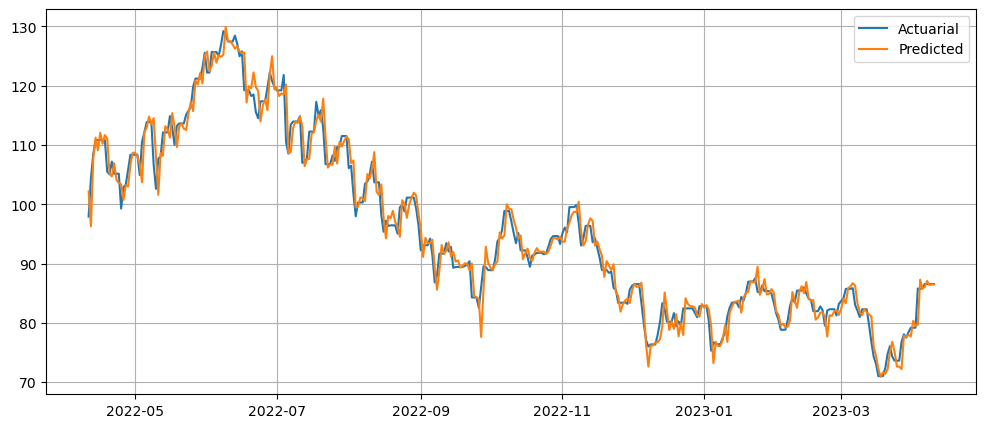

In [13]:
plt.figure(figsize = (12, 5))
plt.plot(test_time, y, label = 'Actuarial')
plt.plot(test_time, yhat, label = 'Predicted')
plt.grid(True)
plt.legend()
plt.show()

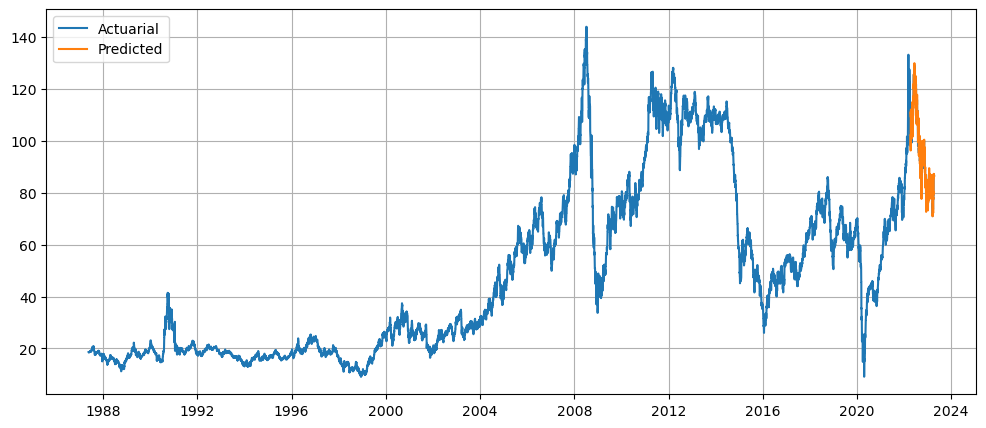

In [14]:
plt.figure(figsize = (12, 5))
plt.plot(df['Date'], df['Price'], label = 'Actuarial')
plt.plot(test_time, yhat, label = 'Predicted')
plt.grid(True)
plt.legend()
plt.show()